# Analysis of light curve periods based on precalculated periods

In this notebook, we describe the process for calculating the periods of `LINEAR` and `ZTF` light curves using the *Lomb-Scargle periodogram*. Afterward, we will save all periods and the number of observation points in a `DataFrame`, which I will then analyze using descriptive statistics. 

In [171]:
# importing all of the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
import random
import pickle

from matplotlib import pyplot as plt
from scipy.stats import norm
from astropy.table import Table

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
#from gatspy import periodic
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries

from ztfquery import lightcurve
from matplotlib import ticker
import dask.dataframe as dd 
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading
import os
import random
from tqdm import tqdm

np.random.seed(42)
%matplotlib inline  

In [2]:
sns.set_theme() # setting the theme for plotting

In [3]:
import sys
sys.path.insert(0,'../src/')
sys.path
from ZTF_data import *
from descriptive_stats import *
from plotting import *
from config import *

Loading the data!
Loading the data!


## What is the Lomb-Scargle periodogram?

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the most prominent strength or the best fit is the actual period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

- $ω$ is the frequency we test to see if it matches our light curve.
- $σ^2$ is the variance of the data. We are dividing by it to normalize the data across all distributions.
- $∑y_k cosω(t_k−τ)$ and $∑y_k sin ω(t_k−τ)$: checking how well the fitted cosine and sine waves align with the data. $t_k$ is the particular time point, and $τ$ is the time delay, for efficiency.
- $∑cos^2 ω(t_k−τ)$ and $∑ sin^2 ω(t_k−τ)$: normalization of the fitting in order to eliminate bias towards powerful or weak wave components. 

## Why do I use the Lomb-Scargle periodogram?

We use the Lomb-Scargle periodogram because it is the most famous tool for determining the periodic variable stars' period. It combines multiple methods of analysis, with its core being in Fourier analysis, and it operates with non-uniformly spaced data, such is the nature of light curves.

## Example: light curve 10032668

As an example to showcase how the Lomb-Scargle algorithm works, calculate the period and phase of the light curve of star 10032668. 

In [4]:
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

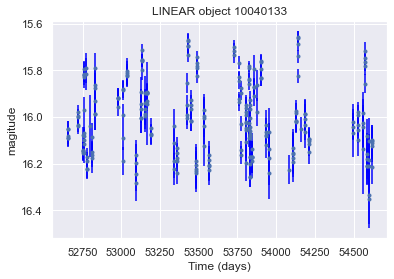

In [5]:
# plotting the light curve

t, mag, mager = data.get_light_curve(data.ids[10]).T
fig, ax = plt.subplots()
ax.errorbar(t, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

It is time to calculate the period. As mentioned before, we use the Lomb-Scargle method, and the function is from the `Astropy` library. 

In [6]:
ls = LombScargle(t, mag, mager) # setting up the Lomb-Scargle object

# calculating the frequency and the power of each frequency for that light curve
frequency, power = ls.autopower(nyquist_factor=350) # here the nyquist factor is pretty high so we do not miss out on a frequency which might be important

# calculating the period
period = 1. / frequency # formula for the period
best_period = period[np.argmax(power)] # choosing the period with the most power
best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power

phase = (t / best_period) % 1 # calculating the phase

In [7]:
best_period

0.6105450399303926

For this light curve, the period is around 0.61 days. This is quite a short period, most likely an RR Lyrae star.

We can plot the Lomb-Scargle periodogram to see each frequency's power.

[(0.2, 1.4), (0.0, 0.8), Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Power')]

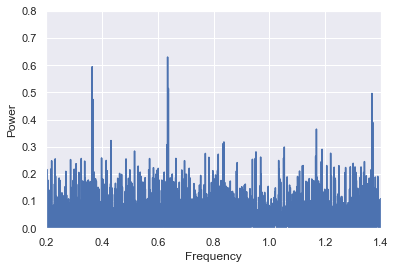

In [8]:
fig, ax = plt.subplots()
ax.plot(frequency, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='Frequency',
       ylabel='Power')

We can see that around 0.6 is the most power. Let us plot the phased light curve!

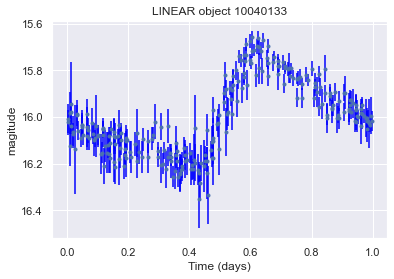

In [9]:
fig, ax = plt.subplots()
ax.errorbar(phase, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

The above plot shows us the structure of the light curve and gives insight into the type of variable star.

# Calculating `LINEAR` periods

We calculate the periods of `LINEAR` light curves using Astropy's `Lomb-Scargle algorithm`, which uses Fourier fitting. Here, we use `nterms=3`, meaning we have 6 Fourier coefficients building our period fit, giving a much higher precision for calculating the periods of single dip light curves. However, it is insufficient for correct period determination of **eclipsing binaries**. These stars would require `nterms=6`; however, this is much too time-consuming and costly to run for 7010 variable stars. The good news is that with `nterms=3`, the period of eclipsing binaries is always twice as little as the correct period, so we can always correct the period later.

In [ ]:
# CALCULATING PERIOD OF LINEAR LIGHT CURVES with nyquist=350, nterms=3
#----------------
name = 'LINEAR_periods'
file_path = '../outputs/'+name+'.csv' # define file path
if os.path.isfile(file_path): # if this file exists
    print('Loading LINEAR data!')
    LINEAR_data = pd.read_csv("../outputs/"+name+".csv") # load the already calculated data
else:
    LC =  {}
    for n, i in enumerate(tqdm(data.ids)):
        t, mag, mager = data.get_light_curve(i).T # get the data for every light curve
        ls = LombScargle(t, mag, mager, nterms=n_terms) # set up a LombScargle object to model the frequency and power
        frequency, power = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power

        period = 1. / frequency # calculating the periods
        best_period = period[np.argmax(power)] # choosing the period with the highest power
        best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power
        N = len(t) # number of points used in calculation

        LC[i] = [best_period, N]     # save values in dictionary with the id as the key

        if (n % 100) == 0:
            # save dictionary to pkl file
            with open('../outputs/LINEAR_periods.pkl', 'wb') as fp:
                pickle.dump(LC, fp)           

    # SAVE AS A DATAFRAME
    # ----------------------
    cols = ['Period', 'N'] # define the columns
    LINEAR_data = pd.DataFrame.from_dict(LC, orient='index', columns=cols) # transfer into a DataFrame based on the index
    LINEAR_data.index.name='index' # name the index
    LINEAR_data.to_csv("../outputs/"+name+".csv") # save the .csv file

Now that we have calculated the periods, we can see the results for the first few light curves.

In [ ]:
LINEAR_data.head()

### Selecting "good" stars

Now, it is time to select the viable periods from all we have calculated since quite a few stars need more data points to calculate the period correctly.

In [ ]:
PeriodsLinear = np.array(LINEAR_data['Period']) # selecting all the periods we just calculated
IDs = [x for x in data.ids] # making a list of ids

In [ ]:
PeriodsLinear[:5] # testing to see if we selected correctly

In [ ]:
# ACCESSING THE OFFICIAL PERIODS
#------------
dataPeriods = fetch_LINEAR_geneva() # accessing the good data
PLorig = 10**(dataPeriods['logP'].T) # accessing the periods
ID_orig = list(dataPeriods['LINEARobjectID'].T) # accessing the good ID's

In [ ]:
ibad = igood = 0 # current number of good and bad star periods, counters
goodPeriodOrig = [] # list for good original periods
goodPeriodNew = [] # list of good newly calculated periods
goodIDs = [] # list of good ID's from our whole dataset
goodOrigIndex = [] # list of the good  ID


# FINDING 'GOOD' LINEAR PERIODS
#---------------------------------
for id in ID_orig: # for every star in the good dataset 
    if id in IDs:# if the original ID is in our list of ID's
        # this star exists in the "geneva" subsample
        index = IDs.index(id) # the index is where the id from the good list is in our list
        goodPeriodOrig.append(PLorig[ID_orig.index(id)]) # append the good period with the correct index
        goodPeriodNew.append(PeriodsLinear[index]) # append the newly calculated period with the correct index
        goodIDs.append(id) # append the correct id
        goodOrigIndex.append(ID_orig.index(id)) # append the index of our id
        igood += 1 # count the number of good stars
    else: 
        # not in the "geneva" list 
        ibad += 1 # count the number of bad stars

# PRINT & assign
#-----------------
PeriodOrig = np.array(goodPeriodOrig)
PeriodNew = np.array(goodPeriodNew)
print(igood, ibad)  

After accessing light curves with adequate data points to determine the period correctly, we save the data as a .txt file. We have calculated that there are 5024 "good" stars.

In [ ]:
# SAVING THE INFORMATION
#---------------------------
# for later perusal in a master file (plus metadata, such as colors)

fout = open('LINEAR_Periods_nterm3.txt', "w") # create a new file in which we can write
fout.write("    LINEAR ID     Porig         Pnew") # write up 3 columns
fout.write("        ra             dec          ug      gi      iK      JK       logP       Ampl    skew    kurt  magMed nObs LCtype \n")    # add the rest of the columns (metadata)
for i in range(0,len(goodIDs)): # for every ID in the new good IDs list
    ID = goodIDs[i] # current ID is the i element in the good list
    Porig = goodPeriodOrig[i] # the original period
    Pnew = goodPeriodNew[i] # the new period
    s = str("%12s " % ID) + str("%12.8f  " % Porig) + str("%12.8f  " % Pnew) # formats values into a string 's', aligning them in columns
    OrigIndex = goodOrigIndex[i] # getting the original index
    LID = dataPeriods[OrigIndex ]['LINEARobjectID'] # accessing the LINEAR ID of that object
    assert ID == LID # asserting that they are the same, so we can continue with the code
    ra = dataPeriods[OrigIndex]['ra'] #accessing the rectascension
    dec = dataPeriods[OrigIndex]['dec'] # accessing the declination
    s = s + str("%12.7f " % ra) + str("%12.7f  " % dec) # formatting previous values into columns
    for q in ['ug','gi','iK','JK']: 
        s = s + str("%7.2f " % dataPeriods[OrigIndex][q]) # loops through the filters and assigns their columns
    s = s + str("%12.8f " % dataPeriods[OrigIndex]['logP']) # adds the logP
    for q in ['Ampl','skew','kurt','magMed']: # loops through the rest of the statistics
        s = s + str("%7.2f " % dataPeriods[OrigIndex][q]) # formats the statistics
    s = s + str("%4.0f " % dataPeriods[OrigIndex]['nObs'])  # adds number of observations
    s = s + str("%2.0f " % dataPeriods[OrigIndex]['LCtype']) # adds light curve type
    s = s + "\n" # next record is in a new line or row
    fout.write(s) # add this string of values as a row
fout.close() # when finished close

## Analysis of `LINEAR` periods

In [10]:
# read data for the master sample of 5204 stars with reliable and reproducible LINEAR periods
colnames = ['ID','Porig','Pnew','ra','dec', 'ug','gi','iK','JK','logP','Ampl','skew','kurt','magMed','nObs','LCtype']
L = Table.read('../outputs/LINEAR_Periods_nterm3.txt', format='ascii', names=colnames)

In [12]:
L

ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
29848,0.55700898,0.55701916,119.526443,46.96212,1.17,0.37,1.02,0.27,-0.2541378,0.62,-0.31,-0.57,16.37,301,1
32086,0.56925794,0.56926594,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.2446909,0.71,-0.49,-1.0,15.02,289,1
50402,0.64329296,0.6432861,119.712975,52.149574,1.18,0.39,1.1,0.2,-0.1915912,0.49,-0.29,-0.88,16.46,284,1
61011,0.662369,0.66237568,118.491257,53.168125,0.81,0.55,1.62,0.2,-0.1789,0.69,-0.03,-1.06,14.08,274,1
62892,0.53077199,0.53076395,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
91437,0.6747281,0.67471133,120.29496,40.932457,1.18,0.24,1.09,0.37,-0.1708712,0.75,-0.12,-0.93,15.39,177,1
95250,0.31386898,0.31386924,120.124542,40.65662,1.18,-0.14,0.83,0.28,-0.5032516,0.55,0.14,-0.65,16.98,222,2
104455,0.55851803,0.55850723,121.150764,42.483574,1.27,-0.13,1.04,0.74,-0.2529628,0.86,-0.34,-0.13,16.88,119,1
108513,0.47380899,0.47381616,120.915886,42.512482,1.24,-0.05,0.8,0.06,-0.3243967,0.85,-1.17,1.16,16.69,282,1


Now that we have loaded the file, it is time to convert it into a DataFrame so it is easier to work with.

In [13]:
Properties = [] # creating a list
for i in list(L.columns): # for every column in the .txt file
    a = list(L[i]) # append all the values from that column
    Properties.append(a) # create a nested list with all the column values

In [14]:
j = 0 # counter
LINEAR_periods = pd.DataFrame() # we create a new dataframe
for i in list(L.columns): # for every column
    LINEAR_periods.insert(j, i, Properties[j]) # we make a new column with all the data inserted
    j += 1 # update the counter
LINEAR_periods.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


# Calculating `ZTF` periods for RR Lyrae

Now that we have calculated all the periods for LINEAR stars, we will focus only on RR Lyrae variable stars for the rest of this notebook. The reason is that they are the most interesting variable star type for this project since they are proven to exhibit the Blazhko effect. We use given data from the Geneva database based on LINEAR data to differentiate the stars. 

In [15]:
# DIFFERENTIATING THE PERIODS
# dividing the correct period by our period we can differentiate between one dip and eclipsing binaries
Pratio = LINEAR_periods['Porig']/LINEAR_periods['Pnew'] 
print(Pratio[:5])
L1 = LINEAR_periods[(Pratio>0.99)&(Pratio<1.01)]  # one dip
L_EB = LINEAR_periods[(Pratio>1.96)&(Pratio<2.04)]  # eclipsing binaries

0    0.999982
1    0.999986
2    1.000011
3    0.999990
4    1.000015
dtype: float64


In [16]:
L1.head() # one dip stars

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


In [17]:
L_EB.head() # eclipsing binaries

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
1958,15617295,0.556593,0.275862,239.874619,2.882987,1.25,0.15,0.97,0.26,-0.254462,0.58,-0.71,-0.39,15.27,45,1
2983,17249,0.252815,0.126407,117.058571,67.081459,1.61,0.94,1.58,0.68,-0.597197,0.57,1.16,0.44,16.16,178,5
2985,41937,0.261539,0.130770,118.729774,49.897243,1.25,0.66,1.36,0.39,-0.582464,0.42,0.40,-0.77,15.84,252,5
2987,51934,0.244835,0.122417,119.304802,52.414425,1.62,0.97,1.78,0.62,-0.611127,0.67,0.65,-0.73,16.30,227,5
2988,56340,0.324801,0.162400,118.446602,52.062500,1.10,0.53,1.02,0.26,-0.488383,0.40,0.73,-0.37,16.22,275,5


In [18]:
# select RR Lyrae using g-i color and previous light curve classification
Lrrlyr = L1[(L1['gi']>-0.5)&(L1['gi']<0.4)&(L1['LCtype']>0)&(L1['LCtype']<3)]
len(Lrrlyr)

2710

In [19]:
Lrrlyr.head() # RR Lyrae stars

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
5,91437,0.674728,0.674711,120.294960,40.932457,1.18,0.24,1.09,0.37,-0.170871,0.75,-0.12,-0.93,15.39,177,1
6,95250,0.313869,0.313869,120.124542,40.656620,1.18,-0.14,0.83,0.28,-0.503252,0.55,0.14,-0.65,16.98,222,2


In [20]:
Lab = Lrrlyr[Lrrlyr['LCtype']==1] # RR Lyrae AB
Lc = Lrrlyr[Lrrlyr['LCtype']==2] # RR Lyrae C
print(len(Lab), len(Lc))

2144 566


In [21]:
Lab.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
5,91437,0.674728,0.674711,120.294960,40.932457,1.18,0.24,1.09,0.37,-0.170871,0.75,-0.12,-0.93,15.39,177,1
7,104455,0.558518,0.558507,121.150764,42.483574,1.27,-0.13,1.04,0.74,-0.252963,0.86,-0.34,-0.13,16.88,119,1


In [22]:
Lc.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
6,95250,0.313869,0.313869,120.124542,40.656620,1.18,-0.14,0.83,0.28,-0.503252,0.55,0.14,-0.65,16.98,222,2
10,141414,0.335691,0.335695,120.575195,48.373753,1.30,-0.12,0.95,0.32,-0.474060,0.48,0.29,-1.21,16.25,278,2
14,163933,0.339629,0.339633,121.947922,52.004822,1.25,-0.04,0.79,0.34,-0.468995,0.46,0.11,-1.32,15.53,306,2
16,174389,0.334034,0.334031,121.822433,53.538300,1.26,-0.02,0.70,0.24,-0.476209,0.32,0.14,-0.89,15.05,270,2
19,258499,0.401506,0.401502,123.443306,38.050678,1.19,0.00,0.93,0.28,-0.396308,0.35,-0.08,-0.97,15.43,275,2


### Calculating RR Lyrae periods of `ZTF` data

In [23]:
L_ids = [x for x in data.ids] # LINEAR ids
Z_ids = [x for x in range(7010)] # ZTF ids

Before we begin, we must match the `LINEAR` ids and the `ZTF` ids and correctly determine which ids are found in the RR Lyrae set of stars. 


In [24]:
matches = [] # list of matches
for i in range(len(L_ids)): # for every value in LINEAR ids
    m = (L_ids[i], Z_ids[i]) # make a tuple connecting the LINEAR id to the ZTF id
    matches.append(m) # append to master list
print(matches[:5])

[(10003298, 0), (10004892, 1), (10013411, 2), (10021274, 3), (10022663, 4)]


In [25]:
ZTF_rrlyrae = [] # list of RR Lyrae ids

for i in Lrrlyr['ID']: # for every id in the table Lrrlyr of LINEAR RR Lyrae stars
    for j in matches: # for every set in matches
        if i == j[0]: # if the LINEAR ids match
            m = j # we found a ZTF id
            ZTF_rrlyrae.append(m) # which we apped to our master list

In [26]:
ZTF_rrlyrae[:5]

[(29848, 4898), (50402, 5523), (62892, 5921), (91437, 6749), (95250, 6852)]

Now that we have a list of `ZTF` ids corresponding to the `LINEAR` ids of RR Lyrae stars, we can calculate the periods for the following 2710 stars.

In [30]:
# CALCULATING PERIOD OF G ZTF LIGHT CURVES with nyquist=350, nterms=3
#----------------
name = 'ZTF_rr_periods_G'
file_path = '../outputs/'+name+'.csv' # define file path
if os.path.isfile(file_path): # if this file exists
    print('Loading ZTF data!')
    ZTF_periods = pd.read_csv("../outputs/"+name+".csv") # load the already calculated data
else:
    LC =  {}
    for n, i in enumerate(tqdm(ZTF_rrlyrae)):
        if ZTF_data[i[1]][1].shape[0] > 0:
            t, mag, mager = ZTF_data[i[1]][1]['mjd'], ZTF_data[i[1]][1]['mag'],ZTF_data[i[1]][1]['magerr'] # get the data for every light curve
            ls = LombScargle(t, mag, mager, nterms=3) # set up a LombScargle object to model the frequency and power
            frequency, power = ls.autopower(nyquist_factor=350)# calculate the frequency and power

            period = 1. / frequency # calculating the periods
            best_period = period[np.argmax(power)] # choosing the period with the highest power
            best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power
            N = len(t) # number of points used in calculation

            LC[i[1]] = [best_period, N]
        else:
            LC[i[1]] = [0, 0]

        if (n % 100) == 0:
            # save dictionary to pkl file
            with open('../outputs/ZTF_rr_periods_dict_G.pkl', 'wb') as fp:
                pickle.dump(LC, fp)

    # SAVE AS A DATAFRAME
    # ----------------------
    cols = ['Period G', 'N G']
    df = pd.DataFrame.from_dict(LC, orient='index', columns=cols)
    df.index.name='index'
    df.to_csv("../outputs/"+name+".csv")

Loading ZTF data!


In [ ]:
# CALCULATING PERIOD OF R ZTF LIGHT CURVES with nyquist=350, nterms=3
#----------------
name = 'ZTF_rr_periods_R'
file_path = '../outputs/'+name+'.csv' # define file path
if os.path.isfile(file_path): # if this file exists
    print('Loading ZTF data!')
    ZTF_periods = pd.read_csv("../outputs/"+name+".csv") # load the already calculated data
else:
    LC =  {}
    for n, i in enumerate(tqdm(ZTF_rrlyrae)):
        if ZTF_data[i[1]][1].shape[0] > 0:
            t, mag, mager = ZTF_data[i[1]][1]['mjd'], ZTF_data[i[1]][1]['mag'],ZTF_data[i[1]][1]['magerr'] # get the data for every light curve
            ls = LombScargle(t, mag, mager, nterms=3) # set up a LombScargle object to model the frequency and power
            frequency, power = ls.autopower(nyquist_factor=350)# calculate the frequency and power

            period = 1. / frequency # calculating the periods
            best_period = period[np.argmax(power)] # choosing the period with the highest power
            best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power
            N = len(t) # number of points used in calculation

            LC[i[1]] = [best_period, N]
        else:
            LC[i[1]] = [0, 0]

        if (n % 100) == 0:
            # save dictionary to pkl file
            with open('../outputs/ZTF_rr_periods_dict_R.pkl', 'wb') as fp:
                pickle.dump(LC, fp)

    # SAVE AS A DATAFRAME
    # ----------------------
    cols = ['Period R', 'N R']
    df = pd.DataFrame.from_dict(LC, orient='index', columns=cols)
    df.index.name='index'
    df.to_csv("../outputs/"+name+".csv")

# Analyzing RR Lyrae periods of both `LINEAR` and `ZTF` data

Now that we have both `LINEAR` and `ZTF` periods, we can compare them. 

In [179]:
# CREATING A NEW TABLE
# -----------------------
LC_PERIODS = pd.DataFrame()
LC_PERIODS['LINEAR ID'] = Lrrlyr['ID'] # getting the linear id
LC_PERIODS['ZTF ID'] = ZTF_periods['ZTF index'] # getting the ztf id
LC_PERIODS['LINEAR P'] = Lrrlyr['Pnew'] # getting the linear period
LC_PERIODS['ZTF P'] = ZTF_periods['ZTF period'] # getting the ztf period
LC_PERIODS['Diff'] = LC_PERIODS['LINEAR P'] / LC_PERIODS['ZTF P'] # getting the difference of periods
LC_PERIODS.head()

,LINEAR ID,ZTF ID,LINEAR P,ZTF P,Diff
0,29848,4898.0,0.557019,0.557023,0.999993
2,50402,5921.0,0.643286,0.530769,1.211988
4,62892,6852.0,0.530764,0.313881,1.690970
5,91437,124.0,0.674711,0.558518,1.208039
6,95250,260.0,0.313869,0.473820,0.662422


In [180]:
LC_PERIODS.shape

(2710, 5)

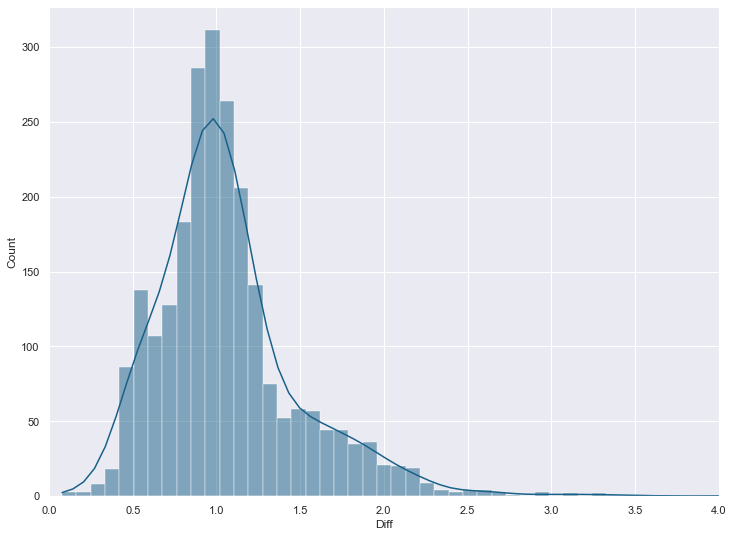

In [181]:
# PLOTTING HISTOGRAM OF DIFFERENCE
#------------------------------------
plt.figure(figsize=(12,9))
sns.histplot(LC_PERIODS, x='Diff', bins=150, color='#176087', kde=True)
plt.xlim([0,4])
plt.show()

From the graph above, we can conclude that most values have a quotient of 1, but many do not. More stars have larger `ZTF` periods than `LINEAR` periods, with a few extreme values cut out of this graph (where `LINEAR` values were above four times greater, all the way to 12). From this, we can conclude that the period values have changed during the ten years the measurements are apart. 

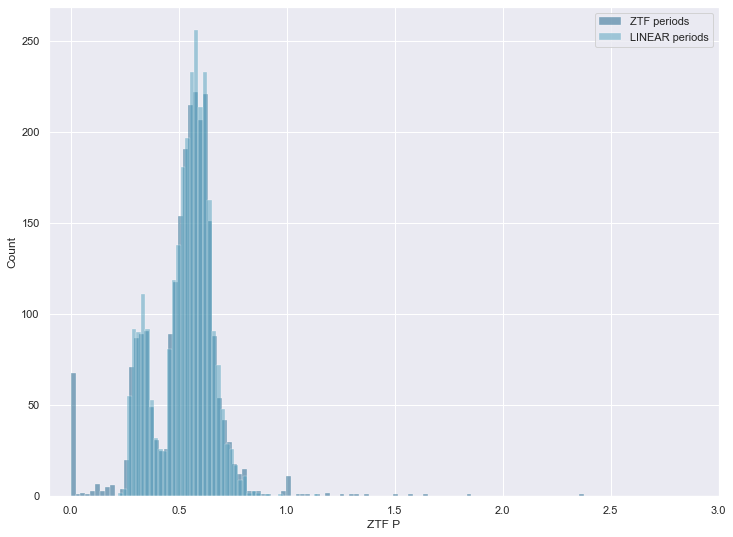

In [191]:
# PLOTTING DISTRIBUTIONS OF PERIODS
#-----------------------------------
plt.figure(figsize=(12, 9))
sns.histplot(LC_INFO, x='ZTF P', color='#176087',label="ZTF periods", alpha=0.5)
sns.histplot(LC_INFO, x='LINEAR P', color='#53A2BE', label="LINEAR periods", alpha=0.5)
plt.xlim([-0.1,3])
plt.legend() 
plt.show()

When we compare the distributions of `LINEAR` and `ZTF` periods, we can see that they match pretty closely, with perhaps slight differences. 

In [192]:
# Checking for NaN values
# -------------------------
c = 0
Z_id = LC_INFO['ZTF ID'].to_numpy()
for i in Z_id:
    if np.isnan(i):
        c += 1
print(c)

250


We notice that 250 stars in the `ZTF` period dataset contain `NaN` values, meaning that there is no data for these stars.

In [87]:
# RMSE
#-------
L = LC_INFO['LINEAR P'].to_numpy()
Z = LC_INFO['ZTF P'].to_numpy()
Z[np.isnan(Z)] = 0

rmse = np.sqrt(np.mean((L-Z))**2)
print(rmse)

0.05183157966027569


Calculating the RMSE metric, or the root mean square error, we see it is around 0.05. It examines the differences between `LINEAR` and `ZTF` data and accentuates significant differences. 

In our scenario, RMSE is relatively small, meaning that the difference between `LINEAR` and `ZTF` is not very prominent, but it is still here—an average difference of 0.05 days or 1.2 hours.

In [193]:
# K-S test
# ---------
from scipy.stats import ks_2samp
ks = ks_2samp(L, Z)
print(ks)

KstestResult(statistic=0.12952029520295202, pvalue=3.2018080213611376e-20, statistic_location=0.2538179868576861, statistic_sign=-1)


Conducting the K-S test tells us if the data comes from the same distribution or if they are very different. A `p value` of less than 0.05 is usually considered a sign that the data does not come from the same distribution and has significant differences. Our value is 3.2e-20, which is a minimal value. This means that the `LINEAR` and `ZTF` periods are not from the same distribution.

### Phasing some light curves

Finally, let us look at the six first RR Lyrae light curves, which are phased. 

In [124]:
L_id = LC_INFO['LINEAR ID'].to_numpy() # creating a list of RR Lyrae LINEAR ids

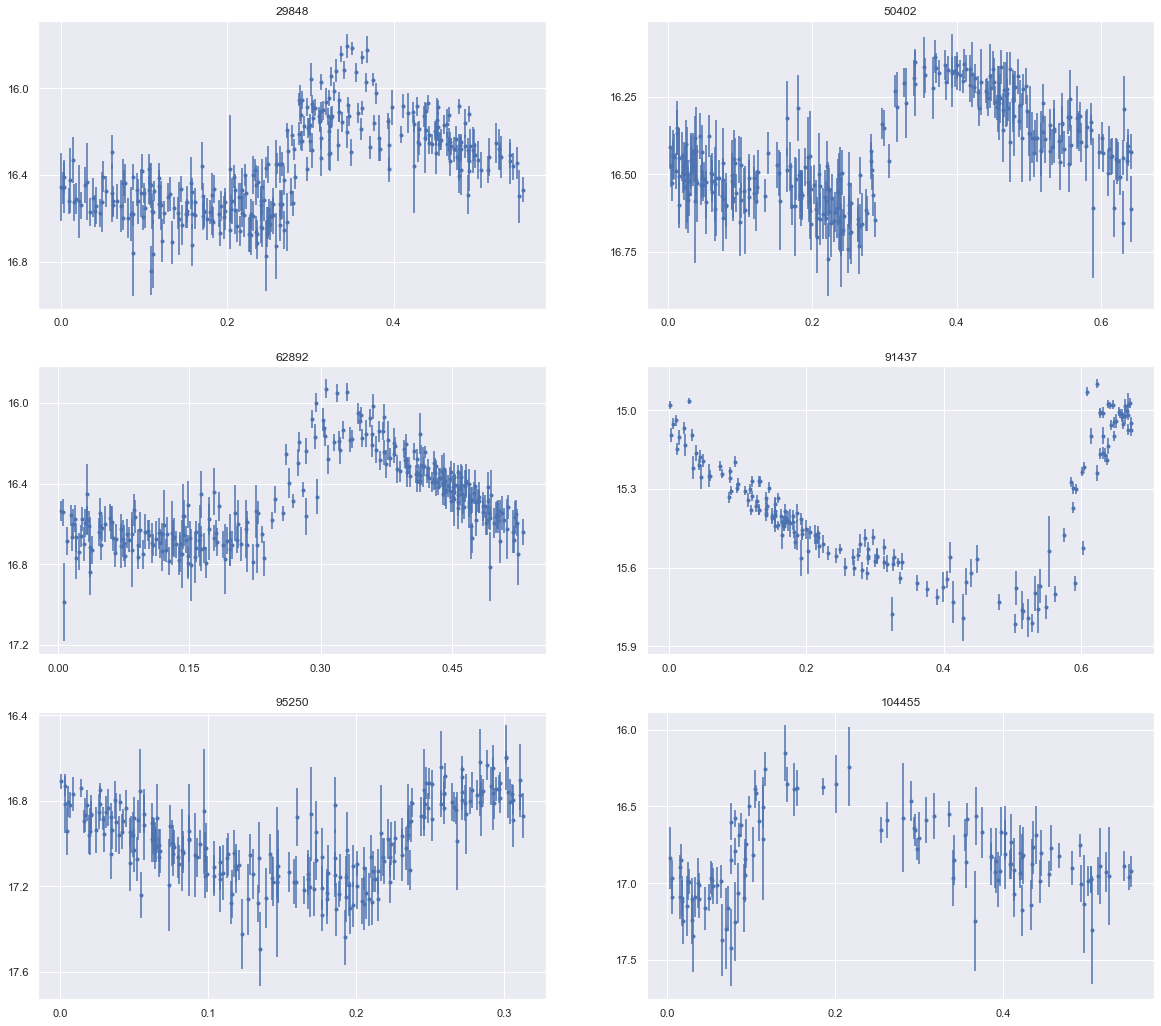

In [198]:
# PHASING LINEAR LIGHT CURVES
# ------------------------------
fig, axs = plt.subplots(3,2, figsize=(20,18)) # creating subplots with 2 columms and 3 rows
axs = axs.flatten()
for i in range(6):
    t, mag, magerr = data.get_light_curve(L_id[i]).T # access the data
    period = LC_INFO['LINEAR P'].to_numpy()[i] # access the period 
    phase = t % period # calculate the phase
    ax = axs[i] 
    ax.errorbar(phase, mag, magerr, fmt='.b', ecolor='b') # draw the light curve
    ax.invert_yaxis()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4)) 
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.set_title(L_id[i])
plt.show()

Looking at the graphs above, we can see that they all have defined shapes reminiscent of RR Lyrae light curves. We can also notice that the errors are pretty significant.

In [196]:
ZTF = data_ztf() # accessing ZTF data

Z_id = LC_INFO['ZTF ID'].to_numpy()
Z_id[np.isnan(Z_id)] = 0 # converting NaN values to 0
Z_id = Z_id.astype(int) # converting ids to int types
Z_id[:5]

Loading the data!


array([4898, 5921, 6852,  124,  260])

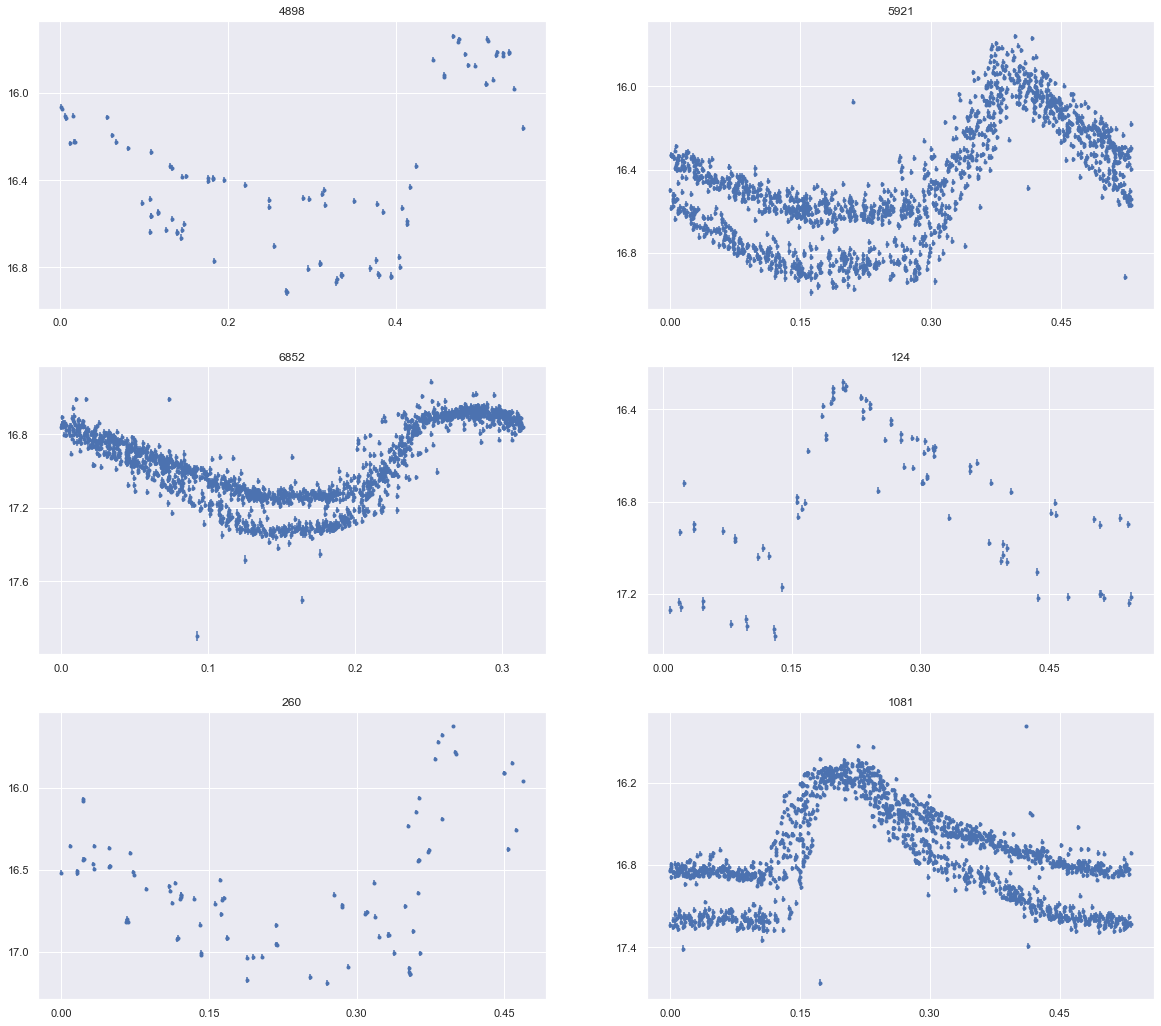

In [197]:
# PHASING ZTF LIGHT CURVES
# ---------------------------
fig, axs = plt.subplots(3,2, figsize=(20,18)) # creating subplots with 2 columms and 3 rows
axs = axs.flatten()
for i in range(6):
    lc = ZTF[Z_id[i]][1]
    time, mag, mag_error = lc['mjd'], lc['mag'], lc['magerr']
    period = LC_INFO['ZTF P'].to_numpy()[i]
    phase = time % period
    ax = axs[i] 
    ax.errorbar(phase, mag, mag_error, fmt='.b', ecolor='b')
    ax.invert_yaxis()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4)) 
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.set_title(Z_id[i])
plt.show()

The graphs above show that each light curve has a primarily defined shape, most of which are reminiscent of RR Lyrae light curve shapes. 

The following steps are analysis of the `ZTF` and `LINEAR` periods of RR Lyrae stars and the fitting of light curves. However, another step we would like to take afterward is to classify the light curves ourselves and continue analyzing eclipsing binaries and other light curve types. 

*Ema Donev, dr. Željko Ivezić 2023.*